# Orchestrating LLMs to Write Diverse Stories with Quality Diversity through AI Feedback

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

Given a creative writing task like "write a story about a spy and a politician," there are many possible interpretations. For instance, we could write a story that ends with the spy getting away with classified information. Or one where the spy and politician put aside their differences and team up to overthrow a government. Or even one where the spy and politician fall in love and leave their lives behind. In short, a wide range of stories exist, each with their own unique plots and details.

<figure style="width: 50%; margin-left: auto; margin-right: auto;">

![](_static/spy-and-politician.png)

<figcaption style="text-align: center; font-style: italic">"An image of a suspicious spy and a rich politician." Generated with ChatGPT.</figcaption>
</figure>

To explore the range of such possibilities, [Quality Diversity through AI Feedback (QDAIF; Bradley 2024)](https://qdaif.github.io/) proposes to orchestrate LLMs in two ways. First, QDAIF uses LLMs to _generate_ new stories. Given a story, QDAIF prompts the LLM to mutate the story into a new one. Second, and equally as important, QDAIF leverages LLMs to _evaluate_ each story, providing the quality and diversity metrics (i.e., objective and measure values). Thus, QDAIF can repeatedly generate and evaluate stories, eventually producing an archive of diverse stories.

In this tutorial, we will demonstrate how to implement a variation of QDAIF in pyribs on the task of writing a story about a spy and a politician. We will describe how to evaluate the objective and measures for each story, set up the QD algorithm components, run the algorithm, and visualize the results.

_Since this tutorial involves running LLMs, we recommend running it on a machine with a GPU, either on Colab or on a local workstation. It should also be possible to run on a standard laptop, although it will be much slower. Alternatively, if you would like to use an API such as OpenAI or Google Gemini, it may also be possible to set that up (more details below)._

## Setup

First, let's set up the prerequisites for this tutorial.

### Python Dependencies

In addition to pyribs, this tutorial depends on [LangChain](https://python.langchain.com/docs/introduction/), a framework for developing LLM applications, and `langchain-ollama`, which is the package that integrates LangChain with Ollama.

In [ ]:
%pip install ribs[visualize] langchain langchain-ollama tqdm

### Instantiating an LLM with LangChain and Ollama

To make this tutorial flexible to the choice of LLM, we use [LangChain](https://python.langchain.com/docs/introduction/). Among other things, LangChain provides a common interface for operating with LLMs from providers like OpenAI and Google. In this tutorial, we will use LangChain's integration with [Ollama](https://ollama.com). Ollama is a framework that enables efficiently running LLMs on local machines. In other words, _we will use LangChain to call an LLM hosted locally by Ollama_.

If you are running this tutorial on your own machine, please follow the [installation instructions](https://ollama.com/download) for Ollama and skip only the cell below. If you are running on Google Colab, we can install Ollama by following the instructions shown below, which were adapted from this [notebook](https://colab.research.google.com/github/5aharsh/collama/blob/main/Ollama_Setup.ipynb) by Saharsh Anand.

**Note:** If you would like to use an LLM from an API like OpenAI or Google Gemini, LangChain also provides integrations for many APIs; more details (such as how to use `init_chat_model`) are available [here](https://python.langchain.com/docs/tutorials/llm_chain/). In that case, feel free to skip this section and instantiate a `model` variable on your own. Note that we assume the model is a _chat model_, i.e., an instance of [BaseChatModel](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html).

In [ ]:
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

After installing Ollama, we start the Ollama server in the background. If Ollama is already running, this cell will output an error that the address is already in use. _This is perfectly fine; simply proceed to the next steps._

In [ ]:
import subprocess
import threading
import time


def run_ollama_serve():
    subprocess.Popen(["ollama", "serve"])


thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)  # Wait for the server to start.

We can now pull the LLM model from Ollama's library and instantiate it in LangChain. We have chosen [Llama 3.1](https://ollama.com/library/llama3.1:8b-instruct-q4_K_M), specifically the 8B parameter model that has been finetuned for instruction following. We choose the `q4_K_M` [quantization](https://github.com/ggml-org/llama.cpp/blob/master/tools/quantize/README.md) as it is a recommended size that balances between speed/memory usage and accuracy. For alternative models, visit the Ollama library [here](https://ollama.com/library). Example alternatives include `llama3.1:70b-instruct-q4_K_M` (70B version of Llama 3.1) and `gpt-oss:20b` (gpt-oss-20b from OpenAI).

In [1]:
from langchain_ollama import ChatOllama

model_name = "llama3.1:8b-instruct-q4_K_M"  # @param ["llama3.1:8b-instruct-q4_K_M","gpt-oss:20b","llama3.1:70b-instruct-q4_K_M"] {"allow-input":true}

# Pull the model from the Ollama library.
!ollama pull {model_name}
print("---")

# Instantiate the model in LangChain.
model = ChatOllama(model=model_name)
print("Model:", model)

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling 667b0c1932bc: 100% ▕██████████████████▏ 4.9 GB                         
pulling 948af2743fc7: 100% ▕██████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4: 100% ▕██████████████████▏  12 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 455f34728c9b: 100% ▕██████████████████▏  487 B                         
verifying sha256 digest 
writing manifest 
success 
---
Model: model='llama3.1:8b-instruct-q4_K_M'


## AI Feedback with an Evaluator

The first ingredient for QDAIF is an evaluator that calls the LLM to provide feedback on the quality and diversity of each story by evaluating the objective and measures. Before creating the evaluator, let us first define the objective and measures for this creative writing domain:

- **Objective:** Is the story about a suspicious spy and a rich politician?
- **Measure 0:** Is the story a romance story?
- **Measure 1:** Does the story have a happy ending?

This domain is adapted from the Stories domain in the original QDAIF paper (Bradley 2023), where the measures were slightly different. Later on, we will present the exact LLM prompts for each of these characteristics.

There are many ways to obtain the LLM's score for the objective and for each measure. For example, the original QDAIF paper predominantly extracts scores by asking the LLM to output an answer like yes or no and analyzing the logits of the tokens associated with that answer. Notably, this approach requires access to the logits output by the LLM, and logits are not always available. Thus, in this tutorial, we instead ask the LLM to output a rating on a scale of 1 to 10 when evaluating the objective and each measure. This approach is general in that it works with any LLM, but a key drawback is that the rating is stochastic and requires multiple evaluations.

Having defined the objective and measures, we now define the `Evaluator` class that calls the LLM to evaluate the objective and measures. Notably, this class takes an `n_evals` parameter that determines how many times to evaluate the objective and each measure. The final score for the objective and each measure is averaged over the ratings from the `n_evals` evaluations.

In [2]:
import numpy as np
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.base import Runnable
from pydantic import BaseModel, Field


class Evaluator:
    """Manages an LLM to compute the objective and measures.

    Args:
        model: Chat model for computing evaluations.
        objective_prompt: Prompt for the objective.
        measure_0_prompt: Prompt for the first measure (measure 0).
        measure_1_prompt: Prompt for the second measure (measure 1).
        n_evals: Number of times to evaluate the objective and each measure.
    """

    def __init__(
        self,
        *,
        model: BaseChatModel,
        objective_prompt: str,
        measure_0_prompt: str,
        measure_1_prompt: str,
        n_evals: int,
    ):
        self.model = model
        self.n_evals = n_evals
        self.min_score = 1
        self.max_score = 10

        # To receive the output from the LLM in a consistent format, we use structured
        # output (https://python.langchain.com/docs/how_to/structured_output/). This
        # Pydantic model defines the schema for receiving ratings from the LLM. Note
        # that the text in the schema class (including class name, field name, field
        # description, docstrings) all have some influence on the LLM output.
        class Rating(BaseModel):
            rating: int = Field(description="The rating on a scale of 1 to 10.")

        # Objective. We first define a chat template, where the `objective_prompt`
        # passed in is the system prompt, and the `text` of the story is the user's
        # message. Then, we form a chain that connects this template to the model. We
        # do the same for measure 0 and measure 1 below. For more background on
        # LangChain, refer to the documentation, such as:
        # - https://python.langchain.com/docs/tutorials/llm_chain/
        # - https://python.langchain.com/docs/concepts/lcel/
        self.objective_template = ChatPromptTemplate(
            [("system", objective_prompt), ("user", "{text}")]
        )
        self.objective_chain = (
            self.objective_template | self.model.with_structured_output(Rating)
        )

        # Measure 0.
        self.measure_0_template = ChatPromptTemplate(
            [("system", measure_0_prompt), ("user", "{text}")]
        )
        self.measure_0_chain = (
            self.measure_0_template | self.model.with_structured_output(Rating)
        )

        # Measure 1.
        self.measure_1_template = ChatPromptTemplate(
            [("system", measure_1_prompt), ("user", "{text}")]
        )
        self.measure_1_chain = (
            self.measure_1_template | self.model.with_structured_output(Rating)
        )

    def compute_score(self, chain: Runnable, texts: list[str]):
        """Uses the given chain to compute scores for the given batch of input texts.

        Each text input is evaluated `n_evals` times.

        Two values are returned:
        - The first value is `all_scores`, which is a list where each entry contains the
          `n_evals` scores for each text.
        - The second is `mean_scores`, which is the mean score for each piece of text.
        """
        inputs = [{"text": text} for text in texts for _ in range(self.n_evals)]
        outputs = chain.batch(inputs)

        all_scores = []
        mean_scores = []

        for i in range(0, len(outputs), self.n_evals):
            results = outputs[i : i + self.n_evals]
            scores = []
            for r in results:
                # Note: this assumes the schema for each result has a `rating` field,
                # which may not be the case if you modify the schema above.
                score = np.clip(r.rating, self.min_score, self.max_score)
                scores.append(score)

            scores = np.asarray(scores)
            all_scores.append(scores)
            mean_scores.append(scores.mean())

        return all_scores, np.asarray(mean_scores)

    def evaluate(self, texts: list[str]):
        objectives = self.compute_score(self.objective_chain, texts)[1]
        measure_0 = self.compute_score(self.measure_0_chain, texts)[1]
        measure_1 = self.compute_score(self.measure_1_chain, texts)[1]
        measures = np.stack((measure_0, measure_1), axis=1)
        return objectives, measures

Having defined the `Evaluator`, we now instantiate it with the `model`, the prompts for the objective and measures, and the number of evaluations `n_evals`. Each prompt starts with defining a characteristic of the story and ends with asking the LLM to output a rating from 1 to 10. Feel free to customize the prompts to specify different objectives and measures!

In [3]:
evaluator = Evaluator(
    model=model,
    objective_prompt="Determine if the input text contains a high-quality short story containing two characters, a suspicious spy, and a rich politician. For example, a high-quality short story would have good flow, interesting plot, and not repeat similar sentences or undesired items such as titles and URLs. Output your rating on a scale of 1 to 10. Output only a single integer.",
    measure_0_prompt="Determine if the input text is a romance story. For example, a romance story talks about two characters who fall in love with each other. Output your rating on a scale of 1 to 10. Output only a single integer.",
    measure_1_prompt="Determine if the input text is a story with a happy ending. For example, a story where the two characters make peach with each other has a happy ending. Output your rating on a scale of 1 to 10. Output only a single integer.",
    n_evals=5,
)

As an example, let's use the `Evaluator` to evaluate two stories.

In [4]:
objectives, measures = evaluator.evaluate(
    [
        "The rich politician, Tom’s life took a turn for the worst - he feared all of his close aides all of a sudden after sensing danger in his clique. There was a civil war going on, and he feared for his life. One day, one of his security guards, turned secret agent, decided to sneak into the classified files room, and spied on Johnny, who was in the room. He wanted to find Johnny’s weakness, and strike at the right time.",
        "Jack was a politician in the city when one day he met Sarah. Sarah had been working for the government as a secret spy. Jack decided he really liked Sarah, and they fell in love. They both quite their jobs and decided to live in the countryside together.",
    ]
)

for i, (obj, meas) in enumerate(zip(objectives, measures)):
    print(f"Story {i} | Objective: {obj}, Measure 0: {meas[0]}, Measure 1: {meas[1]}")

Story 0 | Objective: 7.2, Measure 0: 2.0, Measure 1: 2.4
Story 1 | Objective: 7.4, Measure 0: 8.0, Measure 1: 8.6


## QDAIF Components in pyribs

Like other QD algorithms in pyribs, QDAIF is composed of an archive, emitters, and a scheduler.

### GridArchive for Storing Stories

The archive for QDAIF is a [`GridArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html), which divides the measure space into a grid and stores a story in each grid cell. Below, we specify the dimensions (`dims`) of the grid to be $20 \times 20$, and the `ranges` to be 1 to 10 for each dimension.

For those familiar with the `GridArchive` from previous tutorials, the settings for this `GridArchive` are slightly different since it must store text-based solutions, whereas previous tutorials involved solutions that were continuous vectors. The differences are as follows. First, we set `solution_dim` to be `()`, indicating a scalar value. Second, we set `dtype` such that the `solution` is an `object` (while the `objective` and `measures` remain as floating-point values). This way, the archive can store pieces of text, which are single objects of type `str` (i.e., "scalar" objects).

In [5]:
from ribs.archives import GridArchive

archive = GridArchive(
    solution_dim=(),
    dims=[20, 20],
    ranges=[(1, 10), (1, 10)],
    dtype={"solution": object, "objective": np.float32, "measures": np.float32},
)

### Custom Emitter for Generating New Stories

In pyribs, emitters generate new candidate solutions for evaluation. In the case of QDAIF, the emitter generates new stories by mutating existing ones in the archive. The original QDAIF performed such mutations with Language Model Crossover from [Meyerson 2023](https://arxiv.org/abs/2302.12170). In this tutorial, we differ from the original QDAIF by implementing "directional" variations inspired by PLAN-QD in [Srikanth 2025](https://arxiv.org/abs/2504.03991).

Specifically, the emitter does the following. First, it selects a random story from the archive. Next, for each measure, it selects a random direction, either up or down. For instance, for measure 0 in this tutorial, the story can be made to sound more like a romance story or less like a romance story, and for measure 1, the ending of the story can be made more happy or less happy. Having selected a story and these two random directions (one for each measure), the emitter calls the LLM to mutate the story in the given directions, e.g., "given this story, make the story sound more like a romance story, and make the ending more happy." The result is a new story that is then sent for evaluation.

Finally, note that the emitter below also takes in an `initial_solutions` parameter. These define the initial texts that will be output by the emitter on the first iteration.

In [6]:
from ribs.archives import ArchiveBase
from ribs.emitters import EmitterBase


class LLMDirectionalEmitter(EmitterBase):
    """Uses LLMs to modify pieces of text in random archive directions.

    Args:
        archive: Archive of solutions, e.g., :class:`ribs.archives.GridArchive`. The
            archive must contain solutions of type :class:`str`.
        model: LLM for mutating pieces of text.
        mutation_prompt: Prompt for mutating the text. This prompt must contain fields
            for ``measure_0_direction`` and ``measure_1_direction``.
        measure_*_{down,up}: Prompts indicating directions for mutating the story. Note
            that these directions are inserted into the ``mutation_prompt``.
        batch_size: Number of solutions to return in :meth:`ask`.
        initial_solutions: Initial pieces of text for the LLM.
        seed: Value to seed the random number generator. Set to None to avoid a fixed
            seed.
    """

    def __init__(
        self,
        archive: ArchiveBase,
        *,
        model: BaseChatModel,
        mutation_prompt: str,
        measure_0_down: str,
        measure_0_up: str,
        measure_1_down: str,
        measure_1_up: str,
        batch_size: int,
        initial_solutions: list[str],
        seed: int | None = None,
    ):
        EmitterBase.__init__(
            self,
            archive,
            solution_dim=archive.solution_dim,
            bounds=None,
        )

        self.model = model
        self.batch_size = batch_size
        self.initial_solutions = initial_solutions
        self.rng = np.random.default_rng(seed)

        # This template provides the mutation prompt as the LLM's system prompt, and
        # then provides the story as the `text` field.
        self.mutation_template = ChatPromptTemplate(
            [("system", mutation_prompt), ("user", "{text}")]
        )

        # Each measure has two possible directions: up or down.
        self.mutation_dirs = {
            "measure_0": [measure_0_down, measure_0_up],
            "measure_1": [measure_1_down, measure_1_up],
        }

        # Schema for retrieving stories from the model.
        class Story(BaseModel):
            story: str = Field(description="The modified story.")

        self.mutation_chain = (
            self.mutation_template | self.model.with_structured_output(Story)
        )

    def ask(self):
        # When no solutions have been created yet, just return the initial seed texts.
        if self.archive.empty:
            return self.initial_solutions

        # During normal operation, sample new texts and directions to pass to the LLM.
        prompts = []
        for _ in range(self.batch_size):
            # For both measure_0 and measure_1 (hence size=2), choose between the two
            # possible directions.
            dirs = self.rng.choice(2, size=2)

            prompts.append(
                {
                    "text": self._archive.sample_elites(1)["solution"][0],
                    "measure_0_direction": self.mutation_dirs["measure_0"][dirs[0]],
                    "measure_1_direction": self.mutation_dirs["measure_1"][dirs[1]],
                }
            )

        stories = self.mutation_chain.batch(prompts)
        return [s.story for s in stories]

Below, we instantiate the emitter with prompts to enable making the story more/less romantic and the ending more/less happy. We also provide three initial stories (`initial_solutions`) drawn from the QDAIF paper. Feel free to modify any of the prompts or the initial stories.

To save on computation, we have only defined one emitter with a batch size of 1, so we only generate 1 solution per iteration. We also use the same `model` that is used by the `Evaluator`, so that we do not have to load another model. It is certainly possible to increase the batch size of each emitter, create multiple emitters that each perform mutations with different prompts, or use different models than that used in the `Evaluator`. If you have the time, we certainly encourage trying out these ideas!

In [7]:
emitters = [
    LLMDirectionalEmitter(
        archive,
        model=model,
        mutation_prompt="The following is a story about two characters, a suspicious spy, and a rich politician. Modify the story in the following ways: {measure_0_direction}, and {measure_1_direction}. Output only the new story.",
        measure_0_down="make the story sound less like a romance story",
        measure_0_up="make the story sound more like a romance story",
        measure_1_down="make the ending of the story less happy",
        measure_1_up="make the ending of the story more happy",
        batch_size=1,
        initial_solutions=[
            # From QDAIF paper (Appendix A.21).
            "A spy named Joanne wants to infiltrate the premises of Karl Johnson, a highly-influential figure in the city. Karl was a wealthy mayor, and would do anything in his power to suppress any opposing voices. Joanne wanted to figure out what Karl was hiding, but she took a turn for the worse, as she was highly suspicious in her presence outside his home.",
            "The wealthy entrepreneur and member of parliament, Susan, hosted a party at her mansion. She invited all of the residents, as well as an unusual looking man. The man, Dave, was wearing a tacky shirt, and star-shaped glasses, and was actually a spy. He made the whole room laugh with his jokes, and had a secret agenda - to find what Susan does in her private fun room!",
            "The rich politician, Tom’s life took a turn for the worst - he feared all of his close aides all of a sudden after sensing danger in his clique. There was a civil war going on, and he feared for his life. One day, one of his security guards, turned secret agent, decided to sneak into the classified files room, and spied on Johnny, who was in the room. He wanted to find Johnny’s weakness, and strike at the right time.",
        ],
    ),
    # Additional emitters would go here (`emitters` is a list of emitters).
]

### Scheduler for Composing QDAIF

Finally, to compose the archive and emitters for QDAIF together, we define a [`Scheduler`](https://docs.pyribs.org/en/latest/api/ribs.schedulers.Scheduler.html).

In [8]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

## Running QDAIF

With the QDAIF components defined, we can execute QDAIF in the loop below. During this loop, we first call `ask` on the `scheduler`, which generates new stories (`solutions`) by calling the `ask` method defined on `LLMDirectionalEmitter` above. After evaluating the `objectives` and `measures` of the stories, we pass them to the `scheduler` with `tell`, which inserts the stories into the `archive`. Along the way, we regularly log metrics and save the archive data as a CSV.

On a T4 GPU on Colab, this loop should take **~1 hour** to run. It was also tested locally on an RTX A6000 GPU, where it took a similar amount of time to run.

In [9]:
import pickle as pkl
import sys

from tqdm import tqdm, trange

total_itrs = 200

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc="Iterations"):
    solutions = scheduler.ask()
    objectives, measures = evaluator.evaluate(solutions)
    scheduler.tell(objectives, measures)

    if itr % 5 == 0 or itr == total_itrs:
        tqdm.write(
            f"Iteration {itr:5d} | "
            f"Archive Coverage: {archive.stats.coverage * 100:6.3f}%  "
            f"QD Score: {archive.stats.qd_score:6.3f}"
        )

        # Save the archive's data as a CSV, which makes it easy to read the stories.
        archive.data(return_type="pandas").to_csv("qdaif_archive.csv")

Iteration     5 | Archive Coverage:  1.500%  QD Score: 44.800              
Iteration    10 | Archive Coverage:  2.500%  QD Score: 75.000              
Iteration    15 | Archive Coverage:  3.750%  QD Score: 116.600             
Iteration    20 | Archive Coverage:  5.000%  QD Score: 157.200             
Iteration    25 | Archive Coverage:  5.750%  QD Score: 182.400             
Iteration    30 | Archive Coverage:  6.250%  QD Score: 200.400             
Iteration    35 | Archive Coverage:  7.250%  QD Score: 234.200             
Iteration    40 | Archive Coverage:  8.250%  QD Score: 268.400             
Iteration    45 | Archive Coverage:  8.750%  QD Score: 286.000             
Iteration    50 | Archive Coverage:  9.750%  QD Score: 319.400             
Iteration    55 | Archive Coverage: 10.500%  QD Score: 340.600             
Iteration    60 | Archive Coverage: 11.500%  QD Score: 373.800             
Iteration    65 | Archive Coverage: 12.250%  QD Score: 401.400             
Iteration   

## Visualizing the Archive

Using [`grid_archive_heatmap`](https://docs.pyribs.org/en/latest/api/ribs.visualize.grid_archive_heatmap.html) from the [`ribs.visualize`](https://docs.pyribs.org/en/latest/api/ribs.visualize.html) module, we can visualize a heatmap of the archive. This heatmap shows all the stories that were generated. The axes correspond to the two measures, while the color corresponds to the objective.

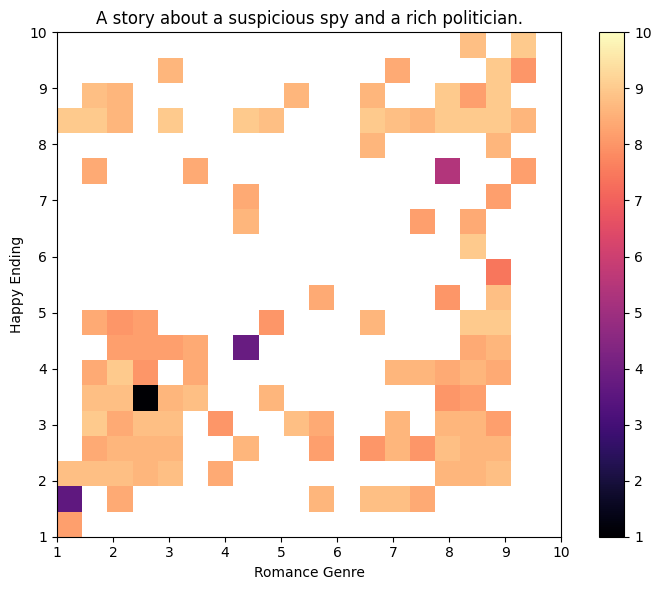

In [23]:
import matplotlib.pyplot as plt
from ribs.visualize import grid_archive_heatmap

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
grid_archive_heatmap(archive, ax=ax, vmin=1, vmax=10)
ax.set_title(f"Iteration {itr}")
ax.set_title("A story about a suspicious spy and a rich politician.")
ax.set_xlabel("Romance Genre")
ax.set_ylabel("Happy Ending")
ax.set_aspect("equal")
fig.tight_layout()

## Retrieving Generated Stories

In [ ]:
archive.retrieve

## Citation

If you find this tutorial useful, please cite it as:

```
@article{pyribs_qdaif,
  title   = {Orchestrating LLMs to Write Diverse Stories with Quality Diversity through AI Feedback},
  author  = {Bryon Tjanaka},
  journal = {pyribs.org},
  year    = {2025},
  url     = {https://docs.pyribs.org/en/stable/tutorials/qdaif.html}
}
```

## Credits

Thank you to [Sid Srikanth](https://sidsrikanth.com/), [Saeed Hedayatian](https://conflictednerd.github.io/), and the members of the ICAROS Lab for their invaluable feedback in developing this tutorial.